In [34]:
### Environment setting
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import seaborn as sns
import csv
import pandas as pd
import re
import pickle

from glob import glob
from torch.utils.data import Dataset, DataLoader, TensorDataset
from numpy.ma.core import squeeze
from pathlib import Path
from sklearn.metrics import confusion_matrix
from collections import Counter
from scipy.signal import find_peaks
from collections import defaultdict
from sklearn.metrics import accuracy_score, classification_report

In [35]:
# load
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('model_2.pkl', 'rb') as f:
    model_2 = pickle.load(f)

In [36]:
work_dir = Path.cwd()

In [37]:
# CNN Module Block
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


# Define a simple CNN model for classification
class ConvNet(torch.nn.Module):
    def __init__(self, input_channels, num_classes=12, num_channels=16, kernel_size=5):
        super(ConvNet, self).__init__()
        self.layers = torch.nn.Sequential(
            ConvBlock(input_channels, num_channels, kernel_size),
            ConvBlock(num_channels, num_channels, kernel_size),
            ConvBlock(num_channels, num_channels, kernel_size),
            ConvBlock(num_channels, num_channels, kernel_size),
            ConvBlock(num_channels, num_channels, kernel_size),
            ConvBlock(num_channels, num_channels, kernel_size),
            ConvBlock(num_channels, num_channels, kernel_size),
            ConvBlock(num_channels, num_channels, kernel_size),
        )
        self.global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Change to 2d pooling
        self.fc = torch.nn.Linear(num_channels, num_classes)

    def forward(self, x):
        x = self.layers(x)
        x = self.global_avg_pool(x).view(x.size(0), -1)  # Flatten to 2d
        network_output = self.fc(x)
        return network_output

In [38]:
# Load the trained CNN model
model_path = work_dir / "ModelSave" / "ConvNet_SNFPR_model.pth"  # Enclose the filename in quotes
model_CNN = ConvNet(input_channels=13, num_classes=12)  # Ensure input_channels and num_classes match your model
model_CNN.load_state_dict(torch.load(model_path))
model_CNN.eval()

ConvNet(
  (layers): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(13, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): ConvBlock(
      (conv): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): ConvBlock(
      (conv): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (4): ConvBlock(
      (conv): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding

In [39]:
# RCD Onset Detection
def compute_rcd_onsets(y, sr, n_fft=2048, hop_length=512, threshold=0.3):
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    mag, phase = np.abs(S), np.angle(S)

    # Estimate phase prediction
    phase_diff = np.diff(phase, axis=1)
    phase_diff = np.pad(phase_diff, ((0, 0), (1, 0)), mode='constant')
    pred = mag[:, :-1] * np.exp(1j * (phase[:, :-1] + phase_diff[:, :-1]))
    error = np.abs(S[:, 1:] - pred)

    # Rectified Complex Domain
    rcd = np.where(mag[:, 1:] >= mag[:, :-1], error, 0)
    onset_env = np.sum(rcd, axis=0)

    # Normalize and peak pick
    onset_env = onset_env - np.mean(onset_env)
    onset_env /= np.std(onset_env) + 1e-8
    peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=3,delta=threshold, wait=5)

    # Convert frames to samples
    onset_samples = librosa.frames_to_samples(peaks, hop_length=hop_length)

    # Append the end of audio to capture the last stroke
    if onset_samples[-1] < len(y):
        onset_samples = np.append(onset_samples, len(y))

    return onset_samples, onset_env

In [40]:
# Function to preprocess audio data
def preprocess(audio_data, sample_rate):
    # Normalize the audio data
    if np.max(np.abs(audio_data)) > 0:
        audio_data = audio_data / np.max(np.abs(audio_data))

    # Extract MFCCs (13 coefficients)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)

    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate, n_chroma=13)

    # Ensure both features have the same number of time frames
    min_frames = min(mfccs.shape[1], chroma.shape[1])
    mfccs = mfccs[:, :min_frames]
    chroma = chroma[:, :min_frames]

    # Stack features along a new dimension to create a 3D array
    # Shape: (n_features, n_time_frames, n_feature_types)
    features = np.stack([mfccs, chroma], axis=2)


    return features

In [41]:
note_labels = ["Dha", "Dhin", "Ghe", "Kat", "Ki", "Na", "Re", "T", "Ta", "Ti", "Tun", "Tin"]

In [42]:
# Function to adjust the length of audio data
def Adjust_Length(audio_data, target_length):
    # Right zero-padding
    if len(audio_data) < target_length:
        padded_audio = np.pad(audio_data, (0, target_length - len(audio_data)), mode = 'constant')
        return padded_audio
    else:
        return audio_data

In [43]:
def predict_tabla_bols(
    file_path,
    model,
    adjust_length_fn,
    target_length,
    db_threshold=-30,
    pre_onset_samples=1000
):
    # Load audio
    y, sr = librosa.load(file_path, sr=None)

    # Compute RCD-based onsets
    onset_samples, onset_env = compute_rcd_onsets(y, sr)

    # Manually add 0 if missing at start
    if 0 not in onset_samples:
        initial_db = librosa.amplitude_to_db([np.max(np.abs(y[:2048]))])[0]
        print(f"Added onset at 0s manually (initial dB: {initial_db:.2f})")
        onset_samples = np.insert(onset_samples, 0, 0)

    results = []
    duration = []
    t_axis = np.linspace(0, len(y) / sr, len(y))
    plt.figure(figsize=(12, 5))
    plt.plot(t_axis, y, label="Waveform", color="skyblue", linewidth=1)

    print(f"Detected {len(onset_samples) - 1} strokes")

    for i in range(len(onset_samples) - 1):
        start = max(onset_samples[i] - pre_onset_samples, 0)
        end = onset_samples[i + 1]
        duration_samples = end - start
        duration_sec = duration_samples / sr
        duration.append(duration_sec)
        stroke = y[start:end]

        if stroke.shape[0] == 0:
            print(f"Skipping stroke {i+1}: zero-length.")
            continue

        stroke_db = librosa.amplitude_to_db([np.max(np.abs(stroke))])[0]
        if stroke_db < db_threshold:
            print(f"Skipping stroke {i+1}: below dB threshold ({stroke_db:.2f} dB).")
            continue

        # Preprocess
        adjusted = adjust_length_fn(stroke, target_length)
        features = preprocess(adjusted, sr)
        input_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)

        # Predict
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            pred_index = torch.argmax(output, dim=1).item()
            predicted_bol = note_labels[pred_index]

        results.append(predicted_bol)
        print(f"Stroke {i+1}: Predicted → {predicted_bol} (dB: {stroke_db:.2f})")

        # Plot
        t_stroke = t_axis[start:end]
        plt.plot(t_stroke, y[start:end] + 1.1 - 0.2 * i, label=f"Stroke {i+1}: {predicted_bol}", linewidth=2)

    plt.title("Detected Strokes with Predictions")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results, duration

Added onset at 0s manually (initial dB: -51.77)
Detected 17 strokes
Skipping stroke 1: below dB threshold (-51.77 dB).
Stroke 2: Predicted → Dhin (dB: -1.08)
Stroke 3: Predicted → Dhin (dB: -8.77)
Stroke 4: Predicted → Dha (dB: -4.78)
Stroke 5: Predicted → Ghe (dB: -7.58)
Stroke 6: Predicted → Ti (dB: -9.38)
Stroke 7: Predicted → Ti (dB: -6.70)
Stroke 8: Predicted → T (dB: -5.96)
Stroke 9: Predicted → Na (dB: -9.19)
Stroke 10: Predicted → Kat (dB: -4.68)
Stroke 11: Predicted → Tin (dB: -4.75)
Stroke 12: Predicted → Dha (dB: -4.07)
Stroke 13: Predicted → Ghe (dB: -8.47)
Stroke 14: Predicted → Ti (dB: -7.68)
Stroke 15: Predicted → Ti (dB: -6.56)
Stroke 16: Predicted → Dhin (dB: -8.43)
Stroke 17: Predicted → Na (dB: -9.04)


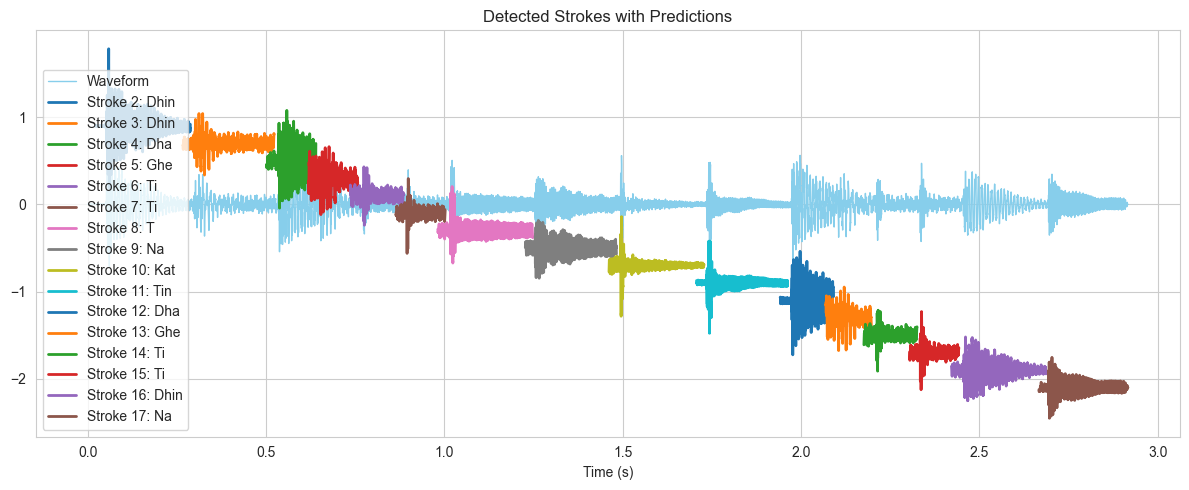

['Dhin', 'Dhin', 'Dha', 'Ghe', 'Ti', 'Ti', 'T', 'Na', 'Kat', 'Tin', 'Dha', 'Ghe', 'Ti', 'Ti', 'Dhin', 'Na'] [0.042666666666666665, 0.26616666666666666, 0.2555, 0.13816666666666666, 0.13816666666666666, 0.14883333333333335, 0.13816666666666666, 0.26616666666666666, 0.2555, 0.26616666666666666, 0.2555, 0.14883333333333335, 0.1275, 0.14883333333333335, 0.13816666666666666, 0.26616666666666666, 0.24972916666666667]


In [44]:
predicted_normalised, durations = predict_tabla_bols(file_path="DataSet/Kaggle_Dataset/Ektaal/Ektaal-060.wav",model=model_CNN,adjust_length_fn=Adjust_Length,
    target_length=72000)

print(predicted_normalised, durations)

In [46]:
def preprocess_generate (predicted_notes, durations):
    merge_list = []
    for i in range(len(predicted_notes)):
        merge_list.append(note_labels.index(predicted_notes[i]))
        merge_list.append(durations[i])
    return merge_list[len(merge_list) - 6:]

In [47]:
print(preprocess_generate(predicted_notes=predicted_normalised, durations=durations))

[9, 0.14883333333333335, 1, 0.13816666666666666, 5, 0.26616666666666666]


In [48]:
model.predict(preprocess_generate(predicted_notes=predicted_normalised, durations=durations))

/opt/anaconda3/envs/ML312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[9.         0.14883333 1.         0.13816667 5.         0.26616666].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [50]:
def generate_notes (predicted_normalised, durations):
    predicted_notes = []
    predicted_duration = []
    x_test_sample = preprocess_generate(predicted_notes=predicted_normalised, durations=durations)
    for i in range(0,6):
        pred_note = model.predict([x_test_sample])
        pred_duration = model_2.predict([x_test_sample])
        print(note_labels[pred_note[0]], pred_duration[0])
        predicted_notes.append(note_labels[pred_note[0]])
        predicted_duration.append(pred_duration[0])
        x_test_sample = x_test_sample[2:]
        x_test_sample.append(pred_note[0])
        x_test_sample.append(pred_duration[0])
    return predicted_notes, predicted_duration

In [51]:
print(generate_notes(predicted_normalised=predicted_normalised, durations=durations))

Na 0.24993066166666694
Tin 0.20478670095238083
Tin 0.25272839999999996
Na 0.15223073333333348
Dha 0.14977061000000005
Na 0.23954951499999996
(['Na', 'Tin', 'Tin', 'Na', 'Dha', 'Na'], [0.24993066166666694, 0.20478670095238083, 0.25272839999999996, 0.15223073333333348, 0.14977061000000005, 0.23954951499999996])


/opt/anaconda3/envs/ML312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/ML312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/ML312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/ML312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/ML312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomF

In [53]:
# Set this to your dataset folder path
DATASET_PATH = "/Users/shreyagupta/Desktop/Machine_Learning/Group_Project/Project_Tabla_Kaggle/DataSet/TablaSN"


def get_random_sample(note):
    """Returns a random AudioSegment for a given tabla note label"""
    folder = os.path.join(DATASET_PATH, note)
    print(f"🧾 Looking in folder: {folder}")
    files = [f for f in os.listdir(folder) if f.endswith(".wav")]
    if not files:
        raise FileNotFoundError(f"No WAV files found in {folder}")
    chosen = random.choice(files)
    return AudioSegment.from_wav(os.path.join(folder, chosen))


def adjust_duration(audio, target_sec):
    """Trims or pads the audio to match the predicted duration (in seconds)"""
    target_ms = int(target_sec * 1000)
    if len(audio) > target_ms:
        return audio[:target_ms]
    else:
        silence = AudioSegment.silent(duration=target_ms - len(audio))
        return audio + silence


def play_audiosegment(audio):
    """Plays a pydub AudioSegment with blocking using simpleaudio"""
    playback = sa.play_buffer(
        audio.raw_data,
        num_channels=audio.channels,
        bytes_per_sample=audio.sample_width,
        sample_rate=audio.frame_rate,
    )
    playback.wait_done()


def play_sequence(predicted_notes, predicted_durations):
    """Main sampler loop"""
    for note, dur in zip(predicted_notes, predicted_durations):
        note = str(note)
        duration = float(dur)
        try:
            sample = get_random_sample(note)
            sample = adjust_duration(sample, duration)
            print(f"Playing {note} for {round(duration, 3)} sec")
            play_audiosegment(sample)
        except Exception as e:
            print(f"Error with {note}: {e}")


def export_sequence(predicted_notes, predicted_durations, output_path="output.wav"):
    sequence = AudioSegment.silent(duration=0)
    for note, dur in zip(predicted_notes, predicted_durations):
        note = str(note).strip()  # Ensure no whitespace
        duration = float(dur)
        try:
            sample = get_random_sample(note)
            sample = adjust_duration(sample, duration)
            sequence += sample
        except Exception as e:
            print(f"Error with {note}: {e}")
    if len(sequence) == 0:
        print("⚠️ Nothing to export. Sequence is empty.")
        return
    sequence.export(output_path, format="wav")
    print(f"✅ Exported to {output_path}")


In [54]:
export_sequence(predicted_normalised, durations)

🧾 Looking in folder: /Users/shreyagupta/Desktop/Machine_Learning/Group_Project/Project_Tabla_Kaggle/DataSet/TablaSN/Dhin
🧾 Looking in folder: /Users/shreyagupta/Desktop/Machine_Learning/Group_Project/Project_Tabla_Kaggle/DataSet/TablaSN/Dhin
🧾 Looking in folder: /Users/shreyagupta/Desktop/Machine_Learning/Group_Project/Project_Tabla_Kaggle/DataSet/TablaSN/Dha
🧾 Looking in folder: /Users/shreyagupta/Desktop/Machine_Learning/Group_Project/Project_Tabla_Kaggle/DataSet/TablaSN/Ghe
🧾 Looking in folder: /Users/shreyagupta/Desktop/Machine_Learning/Group_Project/Project_Tabla_Kaggle/DataSet/TablaSN/Ti
🧾 Looking in folder: /Users/shreyagupta/Desktop/Machine_Learning/Group_Project/Project_Tabla_Kaggle/DataSet/TablaSN/Ti
🧾 Looking in folder: /Users/shreyagupta/Desktop/Machine_Learning/Group_Project/Project_Tabla_Kaggle/DataSet/TablaSN/T
🧾 Looking in folder: /Users/shreyagupta/Desktop/Machine_Learning/Group_Project/Project_Tabla_Kaggle/DataSet/TablaSN/Na
🧾 Looking in folder: /Users/shreyagupta/Des

In [23]:
import os
import random
import numpy as np
from pydub import AudioSegment
import simpleaudio as sa

# Set this to your dataset folder path
DATASET_PATH = "/Users/shreyagupta/Desktop/Machine_Learning/Group_Project/Project_Tabla_Kaggle/Drum_shots"


def get_random_sample(note):
    """Returns a random AudioSegment for a given tabla note label"""
    folder = os.path.join(DATASET_PATH, note)
    return AudioSegment.from_wav(os.path.join(folder))


def adjust_duration(audio, target_sec):
    """Trims or pads the audio to match the predicted duration (in seconds)"""
    target_ms = int(target_sec * 1000)
    if len(audio) > target_ms:
        return audio[:target_ms]
    else:
        silence = AudioSegment.silent(duration=target_ms - len(audio))
        return audio + silence


def play_audiosegment(audio):
    """Plays a pydub AudioSegment with blocking using simpleaudio"""
    playback = sa.play_buffer(
        audio.raw_data,
        num_channels=audio.channels,
        bytes_per_sample=audio.sample_width,
        sample_rate=audio.frame_rate,
    )
    playback.wait_done()


def play_sequence(predicted_notes, predicted_durations):
    """Main sampler loop"""
    for note, dur in zip(predicted_notes, predicted_durations):
        note = str(note)
        duration = float(dur)
        try:
            sample = get_random_sample(note)
            sample = adjust_duration(sample, duration)
            print(f"Playing {note} for {round(duration, 3)} sec")
            play_audiosegment(sample)
        except Exception as e:
            print(f"Error with {note}: {e}")


def export_sequence(predicted_notes, predicted_durations, output_path="drum_output.wav"):
    sequence = AudioSegment.silent(duration=0)
    for note, dur in zip(predicted_notes, predicted_durations):
        note = str(note).strip()  # Ensure no whitespace
        note_wav = note + ".wav"
        duration = float(dur)
        try:
            sample = get_random_sample(note_wav)
            sample = adjust_duration(sample, duration)
            sequence += sample
        except Exception as e:
            print(f"Error with {note_wav}: {e}")
    if len(sequence) == 0:
        print("⚠️ Nothing to export. Sequence is empty.")
        return
    sequence.export(output_path, format="wav")
    print(f"✅ Exported to {output_path}")




In [24]:
# After playing the tabla prediction
print(predicted_normalised)
print(durations)
export_sequence(predicted_normalised, durations)

['Dhin', 'Dhin', 'Dha', 'Ghe', 'Ti', 'Ti', 'T', 'Na', 'Kat', 'Tin', 'Dha', 'Ghe', 'Ti', 'Ti', 'Dhin', 'Na']
[0.042666666666666665, 0.26616666666666666, 0.2555, 0.13816666666666666, 0.13816666666666666, 0.14883333333333335, 0.13816666666666666, 0.26616666666666666, 0.2555, 0.26616666666666666, 0.2555, 0.14883333333333335, 0.1275, 0.14883333333333335, 0.13816666666666666, 0.26616666666666666, 0.24972916666666667]
✅ Exported to drum_output.wav
